# Binary Classification on Health Data

Logistic regression with Generalised Linear Models. Use regularisation (if needed) and different loss functions

In [1]:
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('./health_data.csv').values
print(type(data), data.shape)
print("class distribution",np.bincount(data[:,-1]))

<class 'numpy.ndarray'> (700, 4)
class distribution [400 300]


In [3]:
np.random.shuffle(data)

train_data=data[0:490,:].astype('float64')
TEST_data=data[490:700,:].astype('float64')

mean = train_data[:,:-1].mean(axis=0,keepdims=True)
stddev = train_data[:,:-1].std(axis=0,keepdims=True)

#normalising data since we'll use optimization algorithms. No closed form solutions exists here.
train_data[:,:-1]-=mean
TEST_data[:,:-1]-=mean
train_data[:,:-1]/=stddev
TEST_data[:,:-1]/=stddev

Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

5
(210, 3) (210, 1)


In [4]:
print(train_data.shape, Cross_Validation_data[0].shape)
print('train size = {}'.format(train_data.shape[0]-Cross_Validation_data[0].shape[0]))
print('val size = {}'.format(Cross_Validation_data[0].shape[0]))
print('test size = {}'.format(TEST_data.shape[0]))

(490, 4) (98, 4)
train size = 392
val size = 98
test size = 210


In [5]:
poly=PolynomialFeatures(1) #this just adds '1' in x i.e. gives augmented X

In [6]:
#assuming y_pred, y_true shape is (n,)
#assuming class 1 is positive, and other is negative
#assuming multi-class such that ypred,ytrue has values in 0,1,2,..,label-1
def classification_performance_metrics(y_pred, y_true):
    n=y_true.shape
    
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    
    
    acc = tp_per_class.sum()/n
    
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        
        precision = TP/(TP+FP) if TP+FP!=0 else 0
        recall = TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0

#         print("class{}".format(i),precision,recall,F1)
    
    performance={}
    performance['acc']=acc
    performance['precision']=precision
    performance['TPR']=recall
    performance['recall']=recall
    performance['F1']=F1
    performance['FPR']=FPR
    return performance

def accuracy(Ypred, Ytrue):
    return ((Ypred==Ytrue).sum())/Ytrue.shape[0]

# Generalised Linear Models 
g(x) = sigma(wT.phi_x) with MAE, MSE and Cross Entropy Loss
   
### Regularisation - 
various forms and their interpretations are explicitly shown in question 2. Here, regularisation is only used to remove overfiting i.e. adding bias into the model. Thus, first we attempt to overfit the model and then regularise if overfitting happens

### SGD - 
implemented on the final model with final loss function

In [27]:
def sigmoid(Z):
    Z = np.clip(Z ,a_min = -100, a_max = 100)
    sig = 1/(1 + np.exp(-Z))
    sig = np.clip(sig,a_min = 10**-7, a_max = 1-(10**-7))
    return sig #shape = n,1

def hypothesis(X, w):
    return sigmoid(X.dot(w)) #shape = n,1

def predict(X, w, threshold=0.5): 
    temp = hypothesis(X,w)
    Ypred = np.ones((X.shape[0],1),dtype='uint8')
    Ypred[temp<threshold]=0
    Ypred.reshape(-1,1)
    return Ypred

def mae_loss(Y_true,Y_pred):
    return (np.absolute(Y_true-Y_pred)).mean()

def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

def cross_entropy_loss(y_true, y_pred):
    return (-np.multiply(y_true,np.log(y_pred)) - np.multiply((1-y_true),np.log(1-y_pred))).mean()

In [28]:
def GradientDescent_MAE(X_train,y_train, X_test,y_test, epochs, lr, alpha, threshold=0.5):    
    train_errors, test_errors = [], []
    train_accs, test_accs = [], []

    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        hypothesis_train = hypothesis(X_train, w)
        hypothesis_test = hypothesis(X_test, w)
        
        gradient = (X_train.T.dot( np.sign(hypothesis_train - y_train)*(hypothesis_train)*(1-hypothesis_train) ) / n) + 2*alpha*w 

        train_errors.append(mae_loss(y_train, hypothesis_train))
        test_errors.append(mae_loss(y_test, hypothesis_test))
        
        y_pred_train = predict(X_train, w, threshold)
        y_pred_test = predict(X_test, w, threshold)

        train_accs.append(accuracy(y_pred_train, y_train))
        test_accs.append(accuracy(y_pred_test, y_test))
        
        w = w - lr * gradient
        
    return y_pred_train, y_pred_test, train_errors, test_errors, train_accs, test_accs

In [29]:
def GradientDescent_MSE(X_train,y_train, X_test,y_test, epochs, lr, alpha, threshold=0.5):        
    train_errors, test_errors = [], []
    train_accs, test_accs = [], []

    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        hypothesis_train = hypothesis(X_train, w)
        hypothesis_test = hypothesis(X_test, w)
        
        gradient = 2*(X_train.T.dot( (hypothesis_train - y_train)*(hypothesis_train)*(1-hypothesis_train) ) / n) + 2*alpha*w #y_train should be n,1

        train_errors.append(mse_loss(y_train, hypothesis_train))
        test_errors.append(mse_loss(y_test, hypothesis_test))
        
        y_pred_train = predict(X_train, w, threshold)
        y_pred_test = predict(X_test, w, threshold)

        train_accs.append(accuracy(y_pred_train, y_train))
        test_accs.append(accuracy(y_pred_test, y_test))
        
        w = w - lr * gradient

    return y_pred_train, y_pred_test, train_errors, test_errors, train_accs, test_accs

In [30]:
def GradientDescent_CrossEntropy(X_train,y_train, X_test,y_test, epochs, lr, alpha, threshold=0.5):  
    train_errors, test_errors = [], []
    train_accs, test_accs = [], []
    
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,1))
    for _ in range(epochs):
        hypothesis_train = hypothesis(X_train, w)
        hypothesis_test = hypothesis(X_test, w)
        
        gradient = (2*((X_train.T).dot(hypothesis_train - y_train)) / n) + 2*alpha*w #y_train should be n,1

        train_errors.append(cross_entropy_loss(y_train, hypothesis_train))
        test_errors.append(cross_entropy_loss(y_test, hypothesis_test))
        
        y_pred_train = predict(X_train, w, threshold)
        y_pred_test = predict(X_test, w, threshold)

        train_accs.append(accuracy(y_pred_train, y_train))
        test_accs.append(accuracy(y_pred_test, y_test))
        
        w = w - lr * gradient
        
    return y_pred_train, y_pred_test, train_errors, test_errors, train_accs, test_accs

In [31]:
#cross validate 
def cross_validate(Cross_Validation_data, epochs, lr, alpha, loss, threshold=0.5):
    train_error_CV, test_error_CV, train_acc_CV, test_acc_CV = [],[],[],[] #gradient descent curve parameters
    train_performance_CV, test_performance_CV = [],[]
    
    for i,validation_data in enumerate(Cross_Validation_data):
        print('validating on part %u'%i,end='\r')
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

        Phi_X = poly.fit_transform(X_train)
        Phi_Xt = poly.fit_transform(X_test)
        
        if loss=='mae':
            y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent_MAE(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha, threshold=threshold)
        elif loss=='mse':
            y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent_MSE(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha, threshold=threshold)
        elif loss=='crossentropy':
            y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent_CrossEntropy(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha, threshold=threshold)

        train_error_CV.append(train_error)
        test_error_CV.append(test_error)
        train_acc_CV.append(train_acc)
        test_acc_CV.append(test_acc)
        
        train_performance = classification_performance_metrics(y_pred_train[:,-1], y_train[:,-1].astype(np.uint8))
        test_performance = classification_performance_metrics(y_pred_test[:,-1], y_test[:,-1].astype(np.uint8))

        train_performance_CV.append(train_performance)
        test_performance_CV.append(test_performance)

    train_performance={}
    train_performance['acc']=train_performance['precision']=train_performance['TPR']=train_performance['recall']=train_performance['F1']=train_performance['FPR']=0
    test_performance={}
    test_performance['acc']=test_performance['precision']=test_performance['TPR']=test_performance['recall']=test_performance['F1']=test_performance['FPR']=0

    n_cv = len(train_performance_CV)
    for i in range(n_cv): #cross validation of 5
        for key in train_performance:
            train_performance[key]+=train_performance_CV[i][key]
            test_performance[key]+=test_performance_CV[i][key]
    for key in train_performance:
        train_performance[key]/=n_cv
        test_performance[key]/=n_cv

    train_error, test_error, train_acc, test_acc = np.array(train_error_CV).sum(axis=0)/5, np.array(test_error_CV).sum(axis=0)/5, np.array(train_acc_CV).sum(axis=0)/5, np.array(test_acc_CV).sum(axis=0)/5

    return train_error, test_error, train_acc, test_acc, train_performance, test_performance

In [12]:
val_acc_list, val_f1_list, train_acc_list, TEST_acc_list, precision_list, recall_list, f1_list=[],[],[],[],[],[],[]

MAE Loss function

In [13]:
## find appropriate learning rate

# plt.figure(figsize=(16.,6.))
# for lr in [1, .1, .01]:
#     alpha=0
#     train_error, test_error, train_acc, test_acc, _1, _2 = cross_validate(Cross_Validation_data, epochs=200, lr=lr, alpha=alpha)
#     print("train_error, val_error", train_error[-1],test_error[-1])
#     print("train_acc, val_acc", train_acc[-1],test_acc[-1])
#     print()

#     plt.subplot(1,2,1)
#     plt.xlabel('epochs')
#     plt.ylabel('error')
#     plt.plot(train_error,label='train error (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.plot(test_error,label='val error (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.legend()
#     plt.subplot(1,2,2)
#     plt.xlabel('epochs')
#     plt.ylabel('acc')
#     plt.plot(train_acc,label='train acc (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.plot(test_acc,label='val acc (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.legend()
    
# plt.show()

In [14]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_error, test_error, train_acc, test_acc, train_perf, val_perf = cross_validate(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss='mae')
print('validation acc =',val_perf['acc'][0],"; validation macro F1 =",val_perf['F1'])

val_acc_list.append(val_perf['acc'][0])
val_f1_list.append(val_perf['F1'])

validation acc = 0.846938775510204 ; validation macro F1 = 0.8302233663340799


In [15]:
Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = GradientDescent_MAE(Phi_X, train_data[:,-1:].astype(np.uint8), Phi_Xt, TEST_data[:,-1:].astype(np.uint8), epochs=200, lr=1, alpha = 0)
train_performance = classification_performance_metrics(y_pred_train[:,-1], train_data[:,-1].astype(np.uint8))
TEST_performance = classification_performance_metrics(y_pred_TEST[:,-1], TEST_data[:,-1].astype(np.uint8))
print('train acc, TEST acc, macro F1 score')
print( train_performance['acc'][0], TEST_performance['acc'][0], TEST_performance['F1'] )

train_acc_list.append(train_performance['acc'][0])
TEST_acc_list.append(TEST_performance['acc'][0])
precision_list.append(TEST_performance['precision'])
recall_list.append(TEST_performance['recall'])
f1_list.append(TEST_performance['F1'])

train acc, TEST acc, macro F1 score
0.8551020408163266 0.861904761904762 0.8284023668639053


MSE LOSS FUnction

In [16]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_error, test_error, train_acc, test_acc, train_perf, val_perf = cross_validate(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss='mse')
print('validation acc =',val_perf['acc'][0],"; validation macro F1 =",val_perf['F1'])

val_acc_list.append(val_perf['acc'][0])
val_f1_list.append(val_perf['F1'])

validation acc = 0.8551020408163265 ; validation macro F1 = 0.8378777831364038


In [17]:
Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = GradientDescent_MSE(Phi_X, train_data[:,-1:].astype(np.uint8), Phi_Xt, TEST_data[:,-1:].astype(np.uint8), epochs=200, lr=1, alpha = 0)
train_performance = classification_performance_metrics(y_pred_train[:,-1], train_data[:,-1].astype(np.uint8))
TEST_performance = classification_performance_metrics(y_pred_TEST[:,-1], TEST_data[:,-1].astype(np.uint8))
print('train acc, TEST acc, macro F1 score')
print( train_performance['acc'][0], TEST_performance['acc'][0], TEST_performance['F1'] )

train_acc_list.append(train_performance['acc'][0])
TEST_acc_list.append(TEST_performance['acc'][0])
precision_list.append(TEST_performance['precision'])
recall_list.append(TEST_performance['recall'])
f1_list.append(TEST_performance['F1'])

train acc, TEST acc, macro F1 score
0.8571428571428571 0.8571428571428571 0.8170731707317073


Cross Entropy 

In [18]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_error, test_error, train_acc, test_acc, train_perf, val_perf = cross_validate(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss='crossentropy')
print('validation acc =',val_perf['acc'][0],"; validation macro F1 =",val_perf['F1'])

val_acc_list.append(val_perf['acc'][0])
val_f1_list.append(val_perf['F1'])

validation acc = 0.8551020408163265 ; validation macro F1 = 0.8370309021371571


In [19]:
Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = GradientDescent_CrossEntropy(Phi_X, train_data[:,-1:].astype(np.uint8), Phi_Xt, TEST_data[:,-1:].astype(np.uint8), epochs=200, lr=1, alpha = 0)
train_performance = classification_performance_metrics(y_pred_train[:,-1], train_data[:,-1].astype(np.uint8))
TEST_performance = classification_performance_metrics(y_pred_TEST[:,-1], TEST_data[:,-1].astype(np.uint8))
print('train acc, TEST acc, macro F1 score')
print( train_performance['acc'][0], TEST_performance['acc'][0], TEST_performance['F1'] )

train_acc_list.append(train_performance['acc'][0])
TEST_acc_list.append(TEST_performance['acc'][0])
precision_list.append(TEST_performance['precision'])
recall_list.append(TEST_performance['recall'])
f1_list.append(TEST_performance['F1'])

train acc, TEST acc, macro F1 score
0.8571428571428571 0.8571428571428571 0.8148148148148148


In [21]:
# results=np.array([val_acc_list, val_f1_list, train_acc_list, TEST_acc_list, precision_list, recall_list, f1_list])
# np.save('mae_mse_CrEnt.npy',results)
results = np.round(np.load('mae_mse_CrEnt.npy'),4)
results
# df = pd.DataFrame(data=results,index=['Val Acc','Val F1','Train Acc','Test Acc','Precision','Recall','F1'],columns=['MAE','MSE','CrossEntropy'])
# df.to_csv('mae_mse_CrEnt.csv')

array([[0.8469, 0.8551, 0.8551],
       [0.8302, 0.8379, 0.837 ],
       [0.8551, 0.8571, 0.8571],
       [0.8619, 0.8571, 0.8571],
       [0.814 , 0.8272, 0.8354],
       [0.8434, 0.8072, 0.7952],
       [0.8284, 0.8171, 0.8148]])

### Getting ROC curves

In [45]:
TPR,FPR=[],[]
thresholds=np.arange(0,1.1,0.1)
for loss in ['mae','mse','crossentropy']:
    TPR_loss, FPR_loss = [],[]
    for th in thresholds:
        _1, _2, _3, _4, _5, val_perf = cross_validate(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss=loss,threshold=th)
        TPR_loss.append(val_perf['TPR'])
        FPR_loss.append(val_perf['FPR'])
    #since we will plot for class-1, thus reverse - ensuring AUC is positive
    TPR_loss.reverse()
    FPR_loss.reverse()
    TPR.append(TPR_loss)
    FPR.append(FPR_loss)
TPR_FPR=np.array([FPR,TPR])
np.save('logistic_3lossFn_roc.npy',TPR_FPR)
TPR_FPR.shape

(2, 3, 11)

#### Bias Variance decomposition -
using polynomial kernel to go into higher space and possibly overfit

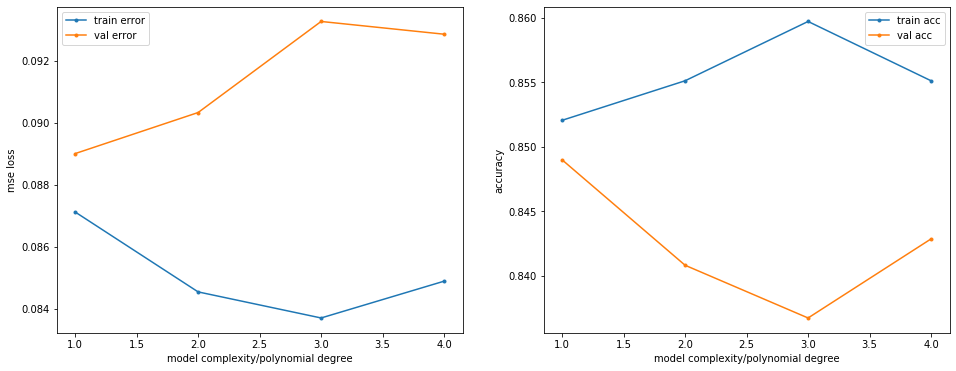

In [34]:
plt.figure(figsize=(16.,6.))
degrees=np.array([1,2,3,4])
alpha,lr=0,1
train_ERROR, val_ERROR, train_ACC, val_ACC = [],[],[],[]
for n in degrees:
    print('n=%u'%n,end='\r')
    poly=PolynomialFeatures(n)
    Phi_X = poly.fit_transform(train_data[:,:-1])
    Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

    train_error, test_error, train_acc, test_acc,_1,_2 = cross_validate(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss='mse')

    train_ERROR.append(train_error[-1])
    val_ERROR.append(test_error[-1])
    train_ACC.append(train_acc[-1])
    val_ACC.append(test_acc[-1])

plt.subplot(1,2,1)
plt.xlabel('model complexity/polynomial degree')
plt.ylabel('mse loss')
plt.plot(degrees, train_ERROR,label='train error',marker='.')
plt.plot(degrees, val_ERROR,label='val error',marker='.')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('model complexity/polynomial degree')
plt.ylabel('accuracy')
plt.plot(degrees, train_ACC,label='train acc',marker='.')
plt.plot(degrees, val_ACC,label='val acc',marker='.')
plt.legend()
plt.savefig('biasVariance_logistic.png')
plt.show()

# Stochastic gradient descent for COMPLETENESS

In [18]:
def StochasticGradientDescent_MAE(X_train,y_train, X_test,y_test, epochs, lr, alpha, threshold=0.5, batch_size=100):        
    train_error, test_error = [], []

    n,m=X_train.shape
    w = np.random.random((m,1)) 
    for _ in range(epochs):
        X_train_mini_batches = np.array_split(X_train, n//batch_size)
        y_train_mini_batches = np.array_split(y_train, n//batch_size)
        for __ in range(len(X_train_mini_batches)):
            X_train_mini_batch = X_train_mini_batches[__]
            y_train_mini_batch = y_train_mini_batches[__]
            
            hypothesis_train = hypothesis(X_train_mini_batch, w)
            hypothesis_test = hypothesis(X_test, w)

            gradient = (y_train_mini_batch.T.dot( np.sign(hypothesis_train - y_train_mini_batch)*(hypothesis_train)*(1-hypothesis_train) ) / batch_size) + 2*alpha*w 

            w = w - lr * gradient
        
            train_error.append(mse_loss(y_train_mini_batch, hypothesis_train))
            test_error.append(mse_loss(y_test, hypothesis_test))
    

    y_pred_train = predict(X_train, w, threshold)
    y_pred_test = predict(X_test, w, threshold)
    return y_pred_train, y_pred_test, train_error, test_error

def StochasticGradientDescent_MSE(X_train,y_train, X_test,y_test, epochs, lr, alpha, threshold=0.5, batch_size=100):        
    train_error, test_error = [], []

    n,m=X_train.shape

    w = np.random.random((m,1)) 
    for _ in range(epochs):
        X_train_mini_batches = np.array_split(X_train, n//batch_size)
        y_train_mini_batches = np.array_split(y_train, n//batch_size)
        for __ in range(len(X_train_mini_batches)):
            X_train_mini_batch = X_train_mini_batches[__]
            y_train_mini_batch = y_train_mini_batches[__]
            
            hypothesis_train = hypothesis(X_train_mini_batch, w)
            hypothesis_test = hypothesis(X_test, w)

            gradient = 2*(X_train_mini_batch.T.dot( (hypothesis_train - y_train_mini_batch)*(hypothesis_train)*(1-hypothesis_train) ) / batch_size) + 2*alpha*w #y_train should be n,1
            
            w = w - lr * gradient
        
            train_error.append(mse_loss(y_train_mini_batch, hypothesis_train))
            test_error.append(mse_loss(y_test, hypothesis_test))
    

    y_pred_train = predict(X_train, w, threshold)
    y_pred_test = predict(X_test, w, threshold)
    return y_pred_train, y_pred_test, train_error, test_error

def StochasticGradientDescent_CrossEntropy(X_train,y_train, X_test,y_test, epochs, lr, alpha, threshold=0.5, batch_size=100):        
    train_error, test_error = [], []

    n,m=X_train.shape

    w = np.random.random((m,1)) 
    for _ in range(epochs):
        X_train_mini_batches = np.array_split(X_train, n//batch_size)
        y_train_mini_batches = np.array_split(y_train, n//batch_size)
        for __ in range(len(X_train_mini_batches)):
            X_train_mini_batch = X_train_mini_batches[__]
            y_train_mini_batch = y_train_mini_batches[__]
            
            hypothesis_train = hypothesis(X_train_mini_batch, w)
            hypothesis_test = hypothesis(X_test, w)

            gradient = (2*((X_train_mini_batch.T).dot(hypothesis_train - y_train_mini_batch)) / batch_size) + 2*alpha*w #y_train should be n,1

            w = w - lr * gradient
        
            train_error.append(cross_entropy_loss(y_train_mini_batch, hypothesis_train))
            test_error.append(cross_entropy_loss(y_test, hypothesis_test))
    

    y_pred_train = predict(X_train, w, threshold)
    y_pred_test = predict(X_test, w, threshold)
    return y_pred_train, y_pred_test, train_error, test_error

In [19]:
#cross validate 
def cross_validate_SGD(Cross_Validation_data, epochs, lr, alpha, loss='mse', threshold=0.5, batch_size=100):
    train_error_CV, test_error_CV = [],[] #gradient descent curve parameters
    train_performance_CV, test_performance_CV = [],[]
    
    for i,validation_data in enumerate(Cross_Validation_data):
        print('validating on part %u'%i,end='\r')
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

        Phi_X = poly.fit_transform(X_train)
        Phi_Xt = poly.fit_transform(X_test)
        
        
        if loss=='mae':
            y_pred_train, y_pred_test, train_error, test_error = StochasticGradientDescent_MAE(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha, threshold=threshold, batch_size=batch_size)
        elif loss=='mse':
            y_pred_train, y_pred_test, train_error, test_error = StochasticGradientDescent_MSE(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha, threshold=threshold, batch_size=batch_size)
        elif loss=='crossentropy':
            y_pred_train, y_pred_test, train_error, test_error = StochasticGradientDescent_CrossEntropy(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha, threshold=threshold, batch_size=batch_size)

        train_error_CV.append(train_error)
        test_error_CV.append(test_error)
        
        train_performance = classification_performance_metrics(y_pred_train[:,-1], y_train[:,-1].astype(np.uint8))
        test_performance = classification_performance_metrics(y_pred_test[:,-1], y_test[:,-1].astype(np.uint8))

        train_performance_CV.append(train_performance)
        test_performance_CV.append(test_performance)

    train_performance={}
    train_performance['acc']=train_performance['precision']=train_performance['TPR']=train_performance['recall']=train_performance['F1']=train_performance['FPR']=0
    test_performance={}
    test_performance['acc']=test_performance['precision']=test_performance['TPR']=test_performance['recall']=test_performance['F1']=test_performance['FPR']=0

    n_cv = len(train_performance_CV)
    for i in range(n_cv): #cross validation of 5
        for key in train_performance:
            train_performance[key]+=train_performance_CV[i][key]
            test_performance[key]+=test_performance_CV[i][key]
    for key in train_performance:
        train_performance[key]/=n_cv
        test_performance[key]/=n_cv

    train_error, test_error = np.array(train_error_CV).sum(axis=0)/5, np.array(test_error_CV).sum(axis=0)/5

    return train_error, test_error, train_performance, test_performance

In [20]:
val_acc_list, val_f1_list, train_acc_list, TEST_acc_list, precision_list, recall_list, f1_list=[],[],[],[],[],[],[]

In [21]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_error, test_error, train_perf, val_perf = cross_validate_SGD(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss='mae')
print('validation acc =',val_perf['acc'][0],"; validation macro F1 =",val_perf['F1'])

val_acc_list.append(val_perf['acc'][0])
val_f1_list.append(val_perf['F1'])

Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

y_pred_train, y_pred_TEST, train_error, TEST_error = StochasticGradientDescent_MSE(Phi_X, train_data[:,-1:].astype(np.uint8), Phi_Xt, TEST_data[:,-1:].astype(np.uint8), epochs=200, lr=1, alpha = 0)
train_performance = classification_performance_metrics(y_pred_train[:,-1], train_data[:,-1].astype(np.uint8))
TEST_performance = classification_performance_metrics(y_pred_TEST[:,-1], TEST_data[:,-1].astype(np.uint8))
print('train acc, TEST acc, macro F1 score')
print( train_performance['acc'][0], TEST_performance['acc'][0], TEST_performance['F1'] )

train_acc_list.append(train_performance['acc'][0])
TEST_acc_list.append(TEST_performance['acc'][0])
precision_list.append(TEST_performance['precision'])
recall_list.append(TEST_performance['recall'])
f1_list.append(TEST_performance['F1'])

validation acc = 0.8285714285714285 ; validation macro F1 = 0.8278112223217434
train acc, TEST acc, macro F1 score
0.8510204081632653 0.8714285714285714 0.8524590163934426


In [22]:
# Stochastic gradient descent for COMPLETENESS
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_error, test_error, train_perf, val_perf = cross_validate_SGD(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss='mse')
print('validation acc =',val_perf['acc'][0],"; validation macro F1 =",val_perf['F1'])

val_acc_list.append(val_perf['acc'][0])
val_f1_list.append(val_perf['F1'])

Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

y_pred_train, y_pred_TEST, train_error, TEST_error = StochasticGradientDescent_MSE(Phi_X, train_data[:,-1:].astype(np.uint8), Phi_Xt, TEST_data[:,-1:].astype(np.uint8), epochs=200, lr=1, alpha = 0)
train_performance = classification_performance_metrics(y_pred_train[:,-1], train_data[:,-1].astype(np.uint8))
TEST_performance = classification_performance_metrics(y_pred_TEST[:,-1], TEST_data[:,-1].astype(np.uint8))
print('train acc, TEST acc, macro F1 score')
print( train_performance['acc'][0], TEST_performance['acc'][0], TEST_performance['F1'] )

train_acc_list.append(train_performance['acc'][0])
TEST_acc_list.append(TEST_performance['acc'][0])
precision_list.append(TEST_performance['precision'])
recall_list.append(TEST_performance['recall'])
f1_list.append(TEST_performance['F1'])

validation acc = 0.846938775510204 ; validation macro F1 = 0.8179149823453621
train acc, TEST acc, macro F1 score
0.8510204081632653 0.8714285714285714 0.8524590163934426


In [23]:
# Stochastic gradient descent for COMPLETENESS
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_error, test_error, train_perf, val_perf = cross_validate_SGD(Cross_Validation_data, epochs=200, lr=1, alpha=0,loss='crossentropy')
print('validation acc =',val_perf['acc'][0],"; validation macro F1 =",val_perf['F1'])

val_acc_list.append(val_perf['acc'][0])
val_f1_list.append(val_perf['F1'])

Phi_X = poly.fit_transform(train_data[:,:-1])
Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

y_pred_train, y_pred_TEST, train_error, TEST_error = StochasticGradientDescent_MSE(Phi_X, train_data[:,-1:].astype(np.uint8), Phi_Xt, TEST_data[:,-1:].astype(np.uint8), epochs=200, lr=1, alpha = 0)
train_performance = classification_performance_metrics(y_pred_train[:,-1], train_data[:,-1].astype(np.uint8))
TEST_performance = classification_performance_metrics(y_pred_TEST[:,-1], TEST_data[:,-1].astype(np.uint8))
print('train acc, TEST acc, macro F1 score')
print( train_performance['acc'][0], TEST_performance['acc'][0], TEST_performance['F1'] )

train_acc_list.append(train_performance['acc'][0])
TEST_acc_list.append(TEST_performance['acc'][0])
precision_list.append(TEST_performance['precision'])
recall_list.append(TEST_performance['recall'])
f1_list.append(TEST_performance['F1'])

validation acc = 0.846938775510204 ; validation macro F1 = 0.8164520601988345
train acc, TEST acc, macro F1 score
0.8510204081632653 0.8714285714285714 0.8524590163934426


In [1]:
import numpy as np
import pandas as pd
# results=np.array([val_acc_list, val_f1_list, train_acc_list, TEST_acc_list, precision_list, recall_list, f1_list])
# np.save('mae_mse_CrEnt_SGD.npy',results)
results = np.round(np.load('mae_mse_CrEnt_SGD.npy'),4)
# results
df = pd.DataFrame(data=results,index=['Val Acc','Val F1','Train Acc','Test Acc','Precision','Recall','F1'],columns=['MAE','MSE','CrossEntropy'])
df.to_csv('mae_mse_CrEnt_SGD.csv')

## regularising overfitted model

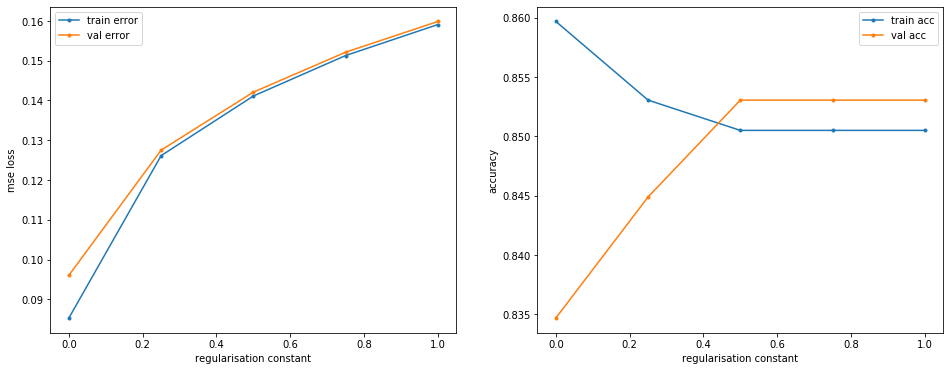

In [48]:
poly=PolynomialFeatures(4)
alphas=list(np.array([0,0.25,0.5,0.75,1]))
lrs=[1,.1,.1,.1,.1]
train_ERROR, val_ERROR, train_ACC, val_ACC = [],[],[],[]
for i,alpha in enumerate(alphas):
    print('alpha=%f'%alpha,end='\r')

    Phi_X = poly.fit_transform(train_data[:,:-1])
    Phi_Xt = poly.fit_transform(TEST_data[:,:-1])

    train_error, test_error, train_acc, test_acc,_1,_2 = cross_validate(Cross_Validation_data, epochs=300, lr=lrs[i], alpha=alpha,loss='mse')
    
    train_ERROR.append(train_error[-1])
    val_ERROR.append(test_error[-1])
    train_ACC.append(train_acc[-1])
    val_ACC.append(test_acc[-1])

plt.figure(figsize=(16.,6.))
plt.subplot(1,2,1)
plt.xlabel('regularisation constant')
plt.ylabel('mse loss')
plt.plot(alphas, train_ERROR,label='train error',marker='.')
plt.plot(alphas, val_ERROR,label='val error',marker='.')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('regularisation constant')
plt.ylabel('accuracy')
plt.plot(alphas, train_ACC,label='train acc',marker='.')
plt.plot(alphas, val_ACC,label='val acc',marker='.')
plt.legend()
plt.savefig('regularising_overfitted_model.png')
plt.show()